# Google Earth Engine Component

## Initialize

In [1]:
#Import required libraries
import ee
import geemap
# import math

# import numpy as np
# import matplotlib.pyplot as plt

# import itertools
# # from varname import nameof

# import pandas as pd
# from time import time

In [2]:
#Initialize Google Earth Engine
# ee.Authenticate() #just needed the 1st time
ee.Initialize()

In [2]:
import imageProcessing

In [4]:
params = {
        'source_image_collection' : 'USDA/NAIP/DOQQ',
        'years' : [2010,2012,2014,2016,2018,2020]
         }

In [5]:
imageProcessing.get_images(params)

{'2010_la_county': <ee.image.Image at 0x7fad40e5e2b0>,
 '2012_la_county': <ee.image.Image at 0x7fad40e5e490>,
 '2014_la_county': <ee.image.Image at 0x7fad40e5e670>,
 '2016_la_county': <ee.image.Image at 0x7fad40e5e850>,
 '2018_la_county': <ee.image.Image at 0x7fad40e5ea30>,
 '2020_la_county': <ee.image.Image at 0x7fad40e5ec10>}

In [23]:
# Check if geemap is working as intended - plot the leaflet map
Map = geemap.Map()

In [31]:
Map

Map(bottom=52708.44140625, center=[33.887651089034975, -118.57652938241915], controls=(WidgetControl(options=[…

## Load Feature Collection - Shapefiles

In [43]:
#Data loads

#loads feature collection data from Google Earth Engine - We can also upload other feature collections
counties = ee.FeatureCollection("TIGER/2018/Counties")

#filter LA County
la_county = counties.filter(ee.Filter.eq('NAME', 'Los Angeles'))
sc_county = counties.filter(ee.Filter.eq('NAME', 'Santa Clara'))

In [44]:
la_county, sc_county

(<ee.featurecollection.FeatureCollection at 0x7f825cf75250>,
 <ee.featurecollection.FeatureCollection at 0x7f825cf750d0>)

In [20]:
#Income Data

la_county_income = ee.FeatureCollection("projects/california-lawn-detection/assets/lacountyincome-final")

# Map.addLayer(la_county_income,{}, 'LA County Income')
# Map.addLayer(sf_county,{}, 'SF COUNTY')

## Load NAIP Imagery

In [ ]:
Map.add

In [42]:
params = {
        'source_image_collection' : 'USDA/NAIP/DOQQ',
        'years' : [2010,2012,2014,2016,2018,2020],
        'counties': {'la_county': la_county, 'sc_county': sc_county}
         }

images = get_images(params)
images

NameError: name 'la_county' is not defined

In [11]:
#see what bands each image has:
images['2020_la_county'].bandNames().getInfo()

['R',
 'G',
 'B',
 'N',
 'R_Entropy',
 'R_Contrast',
 'R_Gearys',
 'G_Entropy',
 'G_Contrast',
 'G_Gearys',
 'B_Entropy',
 'B_Contrast',
 'B_Gearys',
 'N_Entropy',
 'N_Contrast',
 'N_Gearys',
 'NDVI']

In [12]:
#test to see if NAIP plot looks correct
Map.addLayer(images['2020_la_county'], {}, 'NAIP Test')

In [13]:
#test to see if NDVI plot looks correct 
source_image = images['2020_sc_county']

test_ndvi = source_image.normalizedDifference(['N', 'R']).rename('2020_NDVI')
test_ndvi

In [14]:
Map.addLayer(test_ndvi,{min : -1, max : 1, 'palette' : ['blue', 'white', 'green']}, 'NDVI Test')
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

## Load Labeled Data

In [15]:
PROJECT_DIR = 'projects/california-lawn-detection/assets/'

water = ee.FeatureCollection(f"{PROJECT_DIR}water_torrance_0610")
vegetation_trees = ee.FeatureCollection(f"{PROJECT_DIR}trees_torrance")
vegetation_grass = ee.FeatureCollection(f"{PROJECT_DIR}grass_torrance").limit(400)
turf_1 = ee.FeatureCollection(f"{PROJECT_DIR}turf_torrance1")
turf_2 = ee.FeatureCollection(f"{PROJECT_DIR}turf_torrance2")
pv = ee.FeatureCollection(f"{PROJECT_DIR}pv_torrance")
impervious_1 = ee.FeatureCollection(f"{PROJECT_DIR}impervious_torrance1").limit(40)
impervious_2 = ee.FeatureCollection(f"{PROJECT_DIR}impervious_torrance2").limit(40)
soil = ee.FeatureCollection(f"{PROJECT_DIR}soil_torrance").limit(40)

turf = turf_1.merge(turf_2)
impervious= impervious_1.merge(impervious_2)

LABELED_SET = water.merge(vegetation_trees)\
                   .merge(vegetation_grass)\
                   .merge(turf)\
                   .merge(impervious)\
                   .merge(soil)
    
Map.addLayer(LABELED_SET, {}, 'labeled_set')

In [16]:
Map

Map(bottom=754.0, center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(…

## Build Training Set

In [17]:
training_image_params = {
        'source_image_collection' : 'USDA/NAIP/DOQQ',
        'years' : [2020],
        'counties': {'lacounty': la_county}
         }

TRAINING_IMAGE = get_images(training_image_params)['2020_lacounty']

In [18]:
# Overlay the points on the imagery to get training.
LABEL = 'landcover'
BANDS = ['R', 'G', 'B', 'N', 'NDVI',
         'R_Entropy',
         'R_Contrast',
         'R_Gearys',
         'G_Entropy',
         'G_Contrast',
         'G_Gearys',
         'B_Entropy',
         'B_Contrast',
         'B_Gearys',
         'N_Entropy',
         'N_Contrast', 
         'N_Gearys']

training_set = TRAINING_IMAGE.select(BANDS).sampleRegions(**{
  'collection': LABELED_SET,
  'properties': [LABEL],
  'scale': 1
})

In [19]:
set(BANDS)==set(TRAINING_IMAGE.bandNames().getInfo())

True

In [20]:
def training_area(image, training_class):
    
    area = image.reduceRegion(
           reducer = ee.Reducer.count(), 
           geometry = training_class.geometry(), 
           scale = 2, 
           maxPixels = 1e13
                )

    return(area.getInfo().get('B'))

In [21]:
def training_polygons(training_class):
    return(training_class.aggregate_count('label').getInfo())

In [22]:
# training information
training_classes = [water,
                         vegetation_trees,
                         vegetation_grass,
                         turf,
                         pv,
                         impervious,
                         soil]

class_names = ['water',
                         'vegetation_trees',
                         'vegetation_grass',
                         'turf',
                         'pv',
                         'impervious',
                         'soil']

try:
    for i in range(len(training_classes)):
        area_i = training_area(TRAINING_IMAGE, training_classes[i])
        polygons_i = training_polygons(training_classes[i])
        print(class_names[i],"pixels:", area_i ,", polygons", polygons_i)
except:
    print('ERROR. POSSIBLE MISMATCH IN CLASSES LIST AND NAMES LIST SIZES')



water pixels: 486 , polygons 199
vegetation_trees pixels: 17125 , polygons 772
vegetation_grass pixels: 23681 , polygons 400
turf pixels: 857 , polygons 215
pv pixels: 1723 , polygons 344
impervious pixels: 20360 , polygons 80
soil pixels: 8761 , polygons 40


## Separate Training Data into Train/Test

In [23]:
#Split Training and Test Set Randomly - there might be a better way to do this
print("Labeled Set Size in Pixels", training_set.aggregate_count('R').getInfo())
sample = training_set.randomColumn()
trainingSample = sample.filter('random <= 0.8')
validationSample = sample.filter('random > 0.8')
print("Training Set Size in Pixels", trainingSample.aggregate_count('R').getInfo())
print("Test Set Size in Pixels", validationSample.aggregate_count('R').getInfo())

Labeled Set Size in Pixels 284710
Training Set Size in Pixels 227871
Test Set Size in Pixels 56839


## Machine Learning Model

In [24]:
clf = ee.Classifier.smileRandomForest(numberOfTrees = 100).train(trainingSample, LABEL, BANDS)
clf

In [25]:
training_image_classified = TRAINING_IMAGE.select(BANDS).classify(clf)

In [26]:
legend_keys = ['water', 'vegetation_trees', 'vegetation_grass', 'turf','impervious','soil']
legend_colors = ['#0B6AEF', '#097407', '#0CE708', '#8C46D2' ,' #A1A8AF','#D47911']

Map.addLayer(training_image_classified, {'min': 1, 'max': 7, 'palette': legend_colors}, 'Classification')

In [27]:
Map

Map(bottom=1061.0, center=[41.902277040963696, -39.63867187500001], controls=(WidgetControl(options=['position…

## Evaluation Metrics

### Train Accuracy

In [30]:
train_accuracy = trainingSample.classify(clf).errorMatrix('landcover', 'classification')
train_accuracy.getInfo()

[[0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1473, 0, 0, 0, 0, 0, 0],
 [0, 0, 54688, 21, 0, 0, 0, 0],
 [0, 0, 147, 75601, 0, 0, 0, 2],
 [0, 0, 0, 0, 2637, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 65382, 0],
 [0, 0, 0, 0, 0, 0, 1, 27918]]

In [32]:
train_accuracy.accuracy().getInfo()

0.9992451869698207

In [31]:
np.array(train_accuracy.getInfo()).sum()

227871

### Test Accuracy

In [33]:
test_accuracy = validationSample.classify(clf).errorMatrix('landcover', 'classification')

In [35]:
test_accuracy.accuracy().getInfo()

0.9786238322278717

In [34]:
np.array(test_accuracy.getInfo()).sum()

56839

## Binary Classification and Area Calculation

In [28]:
def area_calculation(image, class_number, shape, zcode, pixel_scale = 20):
    
    areaImage = image.eq(class_number).multiply(ee.Image.pixelArea())

#     if zcode:
#         area = areaImage.reduceRegion(
#             reducer = ee.Reducer.sum(), 
#             geometry = shape.geometry(), 
#             scale = pixel_scale, 
#             maxPixels = 1e13)
    
#     else:
    area = areaImage.reduceRegion(
        reducer = ee.Reducer.sum(), 
        geometry = shape, 
        scale = pixel_scale, 
        maxPixels = 1e13)

    
    area_sq_m = area.getInfo().get('classification')
    
    area_sq_km = area_sq_m / 1e6
    
    return area_sq_km

In [29]:
test_image_params = {
        'source_image_collection' : 'USDA/NAIP/DOQQ',
        'years' : [2010,2012, 2014, 2016, 2018,2020],
        'counties': {'lacounty': la_county}
         }

inference_images = get_images(test_image_params)
inference_images

{'2010_lacounty': <ee.image.Image at 0x7fcfb839b6d0>,
 '2012_lacounty': <ee.image.Image at 0x7fcfb839b8b0>,
 '2014_lacounty': <ee.image.Image at 0x7fcfb839ba90>,
 '2016_lacounty': <ee.image.Image at 0x7fcfb839bc70>,
 '2018_lacounty': <ee.image.Image at 0x7fcfb839be50>,
 '2020_lacounty': <ee.image.Image at 0x7fcfb839e070>}

In [47]:
grass_areas = {}

for i in inference_images:
    im = inference_images[i]
    im_classified = im.select(BANDS).classify(clf)
    grass_areas[i] = area_calculation(im_classified, 3, la_county, 20)
    print(i, 'completed')

2010_lacounty completed
2012_lacounty completed
2014_lacounty completed
2016_lacounty completed
2018_lacounty completed
2020_lacounty completed


In [48]:
grass_areas

{'2010_lacounty': 3069.2586644971657,
 '2012_lacounty': 1265.0236710808854,
 '2014_lacounty': 1227.6888985192109,
 '2016_lacounty': 704.2648467338138,
 '2018_lacounty': 1129.6989987678303,
 '2020_lacounty': 826.858711155899}

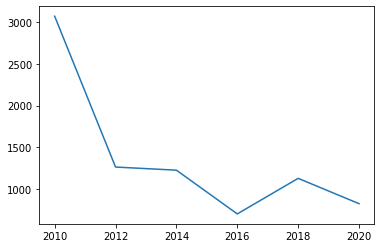

In [49]:
values = np.array(list(grass_areas.values()))
plt.plot(test_image_params['years'], values)

In [50]:
la_county_income_zipcode2 = ee.FeatureCollection("projects/california-lawn-detection/assets/income_zipcode2019")
la_county_income_zipcode = la_county_income_zipcode2.select(ee.List(['zipcode', '2019zipcod','shape_area']), ee.List(['ZipCode', 'Median_Income','Area_sqft']))




In [8]:
a = '3'
type(a)==str

True

In [58]:
Zipcode_list = ['90802','90732','90744','90704','91362','91316']

In [61]:
keys = {'ImageYear','polygon','water_area','vegetation_trees_area', 'vegetation_grass_area', 'turf_area', 'impervious_area','soil_area', 'total_area'}
dictionary = {}
for i in keys:
    dictionary[i] = []

imagery = training_image_classified

    
for i in Zipcode_list:
    start = time()
    polygon = la_county_income_zipcode.filter(ee.Filter.eq('ZipCode', i))

    dictionary['ImageYear'].append(nameof(imagery)) 
    dictionary['polygon'].append(i)
    
    water_area = area_calculation(imagery, 1, polygon, 20)
    dictionary['water_area'].append(water_area)
    
    vegetation_trees_area = area_calculation(imagery, 2, polygon, 20)
    dictionary['vegetation_trees_area'].append(vegetation_trees_area)
    
    vegetation_grass_area = area_calculation(imagery, 3, polygon, 20)
    dictionary['vegetation_grass_area'].append(vegetation_grass_area)
    
    turf_area = area_calculation(imagery, 4, polygon, 20)
    dictionary['turf_area'].append(turf_area)
    
    impervious_area = area_calculation(imagery, 6, polygon, 20)
    dictionary['impervious_area'].append(impervious_area)
    
    soil_area = area_calculation(imagery, 7, polygon, 20)
    dictionary['soil_area'].append(soil_area)

    total_area = water_area + vegetation_trees_area + vegetation_grass_area + turf_area + impervious_area + soil_area
    dictionary['total_area'].append(total_area)
    end = time()
    print(i, f'completed in {end-start} seconds.')

90802 completed in 10.099151134490967 seconds.
90732 completed in 8.45103120803833 seconds.
90744 completed in 8.424124956130981 seconds.
90704 completed in 98.49644899368286 seconds.
91362 completed in 21.4758038520813 seconds.
91316 completed in 49.545308113098145 seconds.


In [62]:
pd.DataFrame(dictionary)

,turf_area,vegetation_trees_area,polygon,water_area,impervious_area,total_area,soil_area,ImageYear,vegetation_grass_area
0,0.164438,0.647374,90802,0.000000,12.688006,14.756617,0.760027,imagery,0.496773
1,0.159726,2.635687,90732,0.000000,2.946216,8.231549,1.869716,imagery,0.620204
2,0.190158,2.017314,90744,0.000000,15.849339,22.599279,3.527528,imagery,1.014940
3,9.193009,66.103575,90704,5.333700,35.695794,341.338173,138.000843,imagery,87.011250
4,0.023005,0.129558,91362,0.057541,1.716988,2.632023,0.202211,imagery,0.502720
5,0.763596,4.772787,91316,0.004292,7.122218,14.764068,0.461717,imagery,1.639458


In [45]:
# classified = training_image_classified

# water_area = area_calculation(classified, 1, la_county, 20)
# vegetation_trees_area = area_calculation(classified, 2, la_county, 20)
# vegetation_grass_area = area_calculation(classified, 3, la_county, 20)
# turf_area = area_calculation(classified, 4, la_county, 20)
# impervious_area = area_calculation(classified, 6, la_county, 20)
# soil_area = area_calculation(classified, 7, la_county, 20)

# total_area = water_area + vegetation_trees_area + vegetation_grass_area + turf_area + impervious_area + soil_area

# water_percentage = water_area / total_area
# vegetation_trees_percentage = vegetation_trees_area / total_area
# vegetation_grass_percentage = vegetation_grass_area / total_area
# turf_percentage = turf_area / total_area
# impervious_percentage = impervious_area / total_area
# soil_percentage = soil_area / total_area